# Salt Lake City Current Active Listings

## Scraping Zillow, Cleaning the Data, and Assigning Geographic Categories

In [2]:
import pandas as pd
import urllib.parse
from matplotlib import pyplot as plt
%matplotlib inline
import requests
import json
from bs4 import BeautifulSoup
import lxml
import csv
import re
import numpy as np
import seaborn as sns

## Formatting the scraped data for active listings

I modified a script to scrape address and other info from Zillow listings based on zip code
reference: https://gist.github.com/scrapehero/5f51f344d68cf2c022eb2d23a2f1cf95

I modified the original script to proceed through multiple search pages, added time between get calls to avoid blacklisting, and added logic to deal with some duplicate data (not sure why this happened).

I then called using a list of 27 zip codes for Salt Lake City. I got a csv file with 833 unique listings.

#### Generating and Loading the data

In [16]:
###    Formatting the scraped data for active listings    ###

#Modified a script to scrape address and other info from Zillow listings based on zip code
#(original script at https://gist.github.com/scrapehero/5f51f344d68cf2c022eb2d23a2f1cf95)

# Modifications were made to proceed through multiple search pages, 
# add time between get calls (to avoid blacklisting), 
# and deal with some duplicate data

# Scraping script was run on list of Salt Lake City zip codes (27 unique codes) 
# using a 'calling script' and the output was saved to a csv file

#Zillow_scraper_pycode jeff$ python zillow_scraper_calls.py


In [420]:
# after saving the csv it was opened in a pandas data frame
address_data = pd.read_csv('~/Desktop/K2_DataScience/K2_Project2/Zillow_Analysis_Salt_Lake_City/zillow_scraper_pycode/properties-slc.csv', 
                           sep=',')

# this display option will make it easier to see price data
pd.options.display.float_format = '{:20,.2f}'.format

#### Data formatting

In [421]:
# don't need real estate provider info so I'll drop this

address_data.drop(['real estate provider'], axis = 1, inplace=True)

In [422]:
# extracted zpid from listing url field and used as index

zpid_list = []
for url in address_data['url']:
    zpid_list.append((((url.split("/")[-2:-1])[0]).split("_")[0]))

address_data['zpid'] = zpid_list

address_data.set_index('zpid', inplace=True)

In [423]:
# fixed inconsistancies in price formatting and converted to as numeric

address_data[['price']] = address_data[['price']].replace('[\$,]','',regex=True)
address_data[['price']] = address_data[['price']].replace('[K,]','000',regex=True)
address_data[['price']] = address_data[['price']].replace('[+,]','',regex=True)
address_data[['price']] = address_data[['price']].replace('[.,]','',regex=True)
address_data[['price']] = address_data[['price']].replace('[M,]','0000',regex=True)
address_data['price'] = pd.to_numeric(address_data['price'])

In [424]:
# formatted all cities to upper case for consistency

address_data['city']= address_data['city'].str.upper()

# manually fixed inconsistancies in city names

address_data[['city']] = address_data[['city']].replace('SLC','SALT LAKE CITY',regex=False)
address_data[['city']] = address_data[['city']].replace('SALT LAKE','SALT LAKE CITY',regex=False)
address_data[['city']] = address_data[['city']].replace('WEST VALLEY','WEST VALLEY CITY',regex=False)

In [425]:
# create a dictionary of facts and features indexed by zpid

fact_feat_dict = {}
for fact_feat in address_data['facts and features'].iteritems():
    if fact_feat[1].endswith('sqft'): # checking for typical structure
        zpid = fact_feat[0]
        string = (fact_feat[1])
        #parsing number of beds
        beds = (re.sub('\sbds?', '', re.split(" , ", string)[0]))
        beds = (beds.replace('Studio', '0'))
        beds = (beds.replace('--', '0'))
        #parsing number of baths
        baths = (re.sub('\sba', '', re.split(" , ", string)[1]))
        baths = (baths.replace('--', '0'))
        #parsing square footage
        sqft = (re.sub('\ssqft', '', re.split(" , ", string)[2]))
        sqft = (sqft.replace('--', '0'))
        sqft = (sqft.replace(',', ''))
        sqft = (sqft.replace('+', ''))
        #saving data to dict with zillow index as key
        temp_dict = {'beds': beds, 'baths': baths, 'sqft': sqft}
        fact_feat_dict[zpid] = temp_dict
    else:         #if structure isn't the normal structure, NaNs are added for room count
        zpid = fact_feat[0]
        temp_dict = {'beds': np.NaN, 'baths': np.NaN, 'sqft': np.NaN}
        fact_feat_dict[zpid] = temp_dict

In [426]:
# create a facts and features data frame and cast as floats

fact_features_df = pd.DataFrame.from_dict(fact_feat_dict, orient='index')
fact_features_df['beds'] = pd.to_numeric(fact_features_df['beds'])
fact_features_df['baths'] = pd.to_numeric(fact_features_df['baths'])
fact_features_df['sqft'] = pd.to_numeric(fact_features_df['sqft'])

In [427]:
# join facts and features to the existing data frame
address_data = address_data.join(fact_features_df, how='left')

In [428]:
# generate a new feature for price/sqft
address_data['price_per_sqft'] = (address_data['price'])/ (address_data['sqft'])

## Checking for Missing Data

In [429]:
address_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 2090375808 to 124782718
Data columns (total 12 columns):
title                 840 non-null object
address               840 non-null object
city                  840 non-null object
state                 840 non-null object
postal_code           840 non-null int64
price                 836 non-null float64
facts and features    840 non-null object
url                   840 non-null object
beds                  774 non-null float64
baths                 774 non-null float64
sqft                  774 non-null float64
price_per_sqft        771 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 125.3+ KB


In [430]:
# test to see if the 'null' objects for the parsed figures (bed, bath, sqft) are incorrectly assigned

misclassified_test_nans = (address_data[((np.isnan(address_data.beds)) | 
                      (np.isnan(address_data.baths)) |
                     (np.isnan(address_data.sqft))) & 
                     (address_data['title'] != 'Lot/Land For Sale')])
len(misclassified_test_nans)

2

In [431]:
# test to see if the '0' objects for the parsed figures (bed, bath, sqft) are incorrectly assigned

misclassified_test_zeros = (address_data[(address_data['title'] != 'Lot/Land For Sale') & 
                     ((address_data['beds'] == 0) | 
                      (address_data['baths'] == 0) |
                      (address_data['sqft'] == 0)
                     )])
len(misclassified_test_zeros)                

17

In [432]:
# all items seem to be parsed satisfactorally
# 0 values for bed, bath, and sqft will be converted to nan so they don't skew the data

cols = ['beds', 'baths', 'sqft']
address_data[cols] = address_data[cols].replace({0:np.nan})

In [433]:
# filtering out listings with nan for price (mostly auctions), beds, bath, size
address_data = address_data[np.isnan(address_data.price)==False]
address_data = address_data[np.isnan(address_data.beds)==False]
address_data = address_data[np.isnan(address_data.baths)==False]
address_data = address_data[np.isnan(address_data.sqft)==False]

## Exploring the Data

In [434]:
address_data.groupby('beds')['sqft'].describe()

,count,mean,std,min,25%,50%,75%,max
beds,,,,,,,,
1.00,20.00,927.30,436.97,471.00,683.00,759.50,952.50,"2,336.00"
2.00,137.00,"1,369.12",579.49,649.00,"1,005.00","1,204.00","1,584.00","4,804.00"
3.00,224.00,"2,143.29",960.21,880.00,"1,449.00","1,894.50","2,499.75","6,200.00"
4.00,182.00,"3,186.01","1,758.91","1,205.00","1,970.00","2,725.00","3,789.00","11,646.00"
5.00,113.00,"4,621.65","3,864.38","1,471.00","2,748.00","3,600.00","4,990.00","32,463.00"
6.00,56.00,"5,251.12","1,820.32","2,118.00","3,802.50","5,376.00","6,114.75","9,414.00"
7.00,19.00,"6,839.26","2,854.74","2,530.00","4,409.00","5,842.00","8,889.50","12,980.00"
8.00,3.00,"4,694.33","1,742.84","3,268.00","3,723.00","4,178.00","5,407.50","6,637.00"
9.00,1.00,"7,126.00",nan,"7,126.00","7,126.00","7,126.00","7,126.00","7,126.00"


In [435]:
address_data['sqft'].describe()

count                 756.00
mean                2,960.69
std                 2,395.35
min                   471.00
25%                 1,518.00
50%                 2,214.50
75%                 3,646.00
max                32,463.00
Name: sqft, dtype: float64

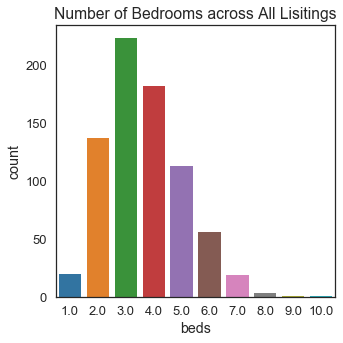

In [436]:
# plotting the number of bedrooms across all listings
sns.set_style("white")
data = address_data
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
ax = sns.countplot(x="beds", data=data).set_title('Number of Bedrooms across All Lisitings')

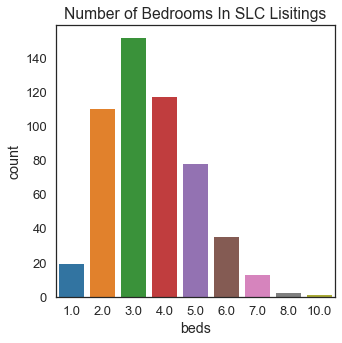

In [437]:
# plotting the number of bedrooms in slc listings
sns.set_style("white")
data= address_data[address_data['city'] == 'SALT LAKE CITY']
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
ax = sns.countplot(x="beds", data=data).set_title('Number of Bedrooms In SLC Lisitings')

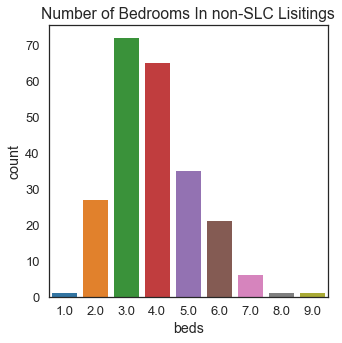

In [438]:
# plotting the number of bedrooms in non-slc listings
sns.set_style("white")
data= address_data[address_data['city'] != 'SALT LAKE CITY']
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
ax = sns.countplot(x="beds", data=data).set_title('Number of Bedrooms In non-SLC Lisitings')

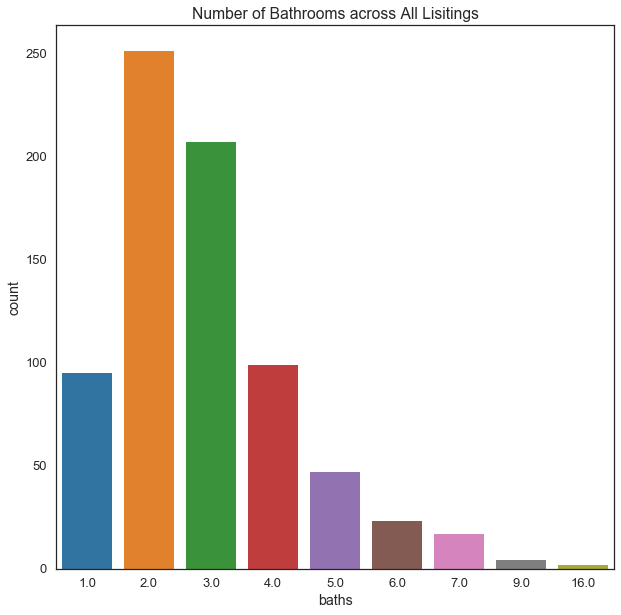

In [439]:
# plotting the number of bathrooms across all listings
data = address_data[(address_data['baths'] !=1.5) & 
                    (address_data['baths'] !=1.75) &
                   (address_data['baths'] != 2.5) &
                   (address_data['baths'] != 2.75) &
                   (address_data['baths'] != 3.5) &
                   (address_data['baths'] != 5.5)]
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
ax = sns.countplot(x="baths", data=data).set_title('Number of Bathrooms across All Lisitings')

(100, 12000)

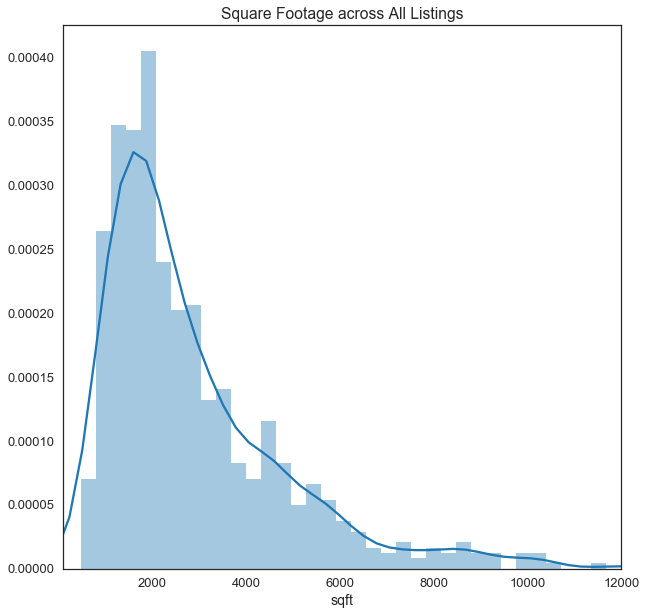

In [440]:
# plotting the square footage across all listings
data = address_data[np.isnan(address_data.sqft)==False]
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
count = sns.distplot(data['sqft'], bins = 100).set_title('Square Footage across All Listings')
plt.xlim(100, 12000)

In [441]:
address_data.groupby('city')['sqft'].describe()

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
BOUNTIFUL,3.00,"2,786.00",944.36,"1,957.00","2,272.00","2,587.00","3,200.50","3,814.00"
BRIGHTON,10.00,"2,337.40","2,033.52",880.00,962.00,"1,017.50","3,363.50","6,709.00"
COTTONWOOD HEIGHTS,9.00,"5,194.89","1,882.31","2,722.00","3,668.00","5,469.00","6,414.00","8,001.00"
EMIGRATION CANYON,1.00,"5,408.00",nan,"5,408.00","5,408.00","5,408.00","5,408.00","5,408.00"
HOLLADAY,43.00,"5,221.26","4,886.59","1,458.00","2,893.50","4,013.00","5,619.00","32,463.00"
KEARNS,2.00,"2,457.50",946.82,"1,788.00","2,122.75","2,457.50","2,792.25","3,127.00"
MILLCREEK,13.00,"3,223.77","1,182.56","1,348.00","2,775.00","3,148.00","3,794.00","5,249.00"
MURRAY,20.00,"2,519.75","1,533.86",658.00,"1,363.25","1,864.00","3,602.50","5,842.00"
NORTH SALT LAKE,5.00,"3,014.60","1,641.85","1,380.00","1,920.00","2,602.00","3,635.00","5,536.00"


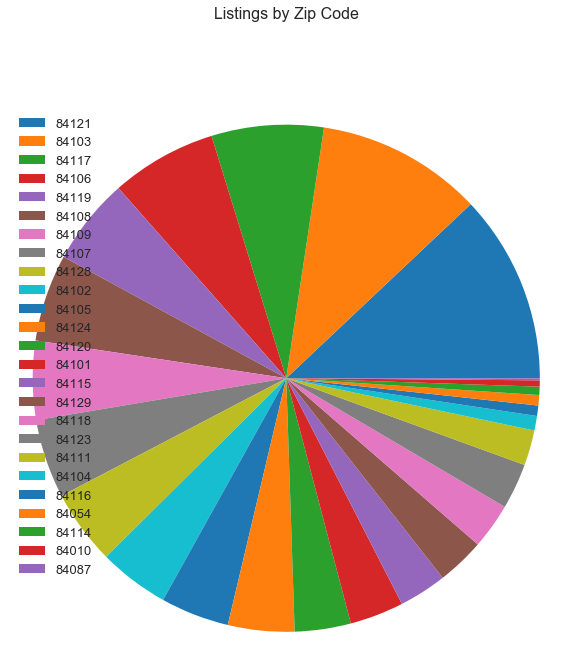

In [442]:
# make df with counts of zip code occurances
# this plot is meaningless. Created a geographically clustered feature below.

df= pd.DataFrame(data=address_data['postal_code'].value_counts(), index=None).reset_index()
df.columns = ['zip_code', 'listing_count']

values = df['listing_count']
labels = df['zip_code']

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
plt.pie(values)
plt.legend(labels, loc="best")
plt.title('Listings by Zip Code', y=1.15, fontsize=16)
plt.axis('equal')
plt.show()

## Adding neighborhood and region classifications
Each listing is associated with a zipcode (27 unique codes), but I also wanted to classify the data by neighborhood (9 unique) and geographic region (4 unique). In terms of size, zipcodes are more granular than neighborhoods, and neighborhoods are more granular than geographic region.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **zipcode < neighborhood < region**

I created a csv that maps zip codes to neighborhoods and a csv that maps neighborhoods to region ('Central', 'East', 'South', and 'North_West'). Note that I categorized Salt Lake City's North and West suburbs into one category since several neighborhoods span these coordinates and the property types are similar. 

In [443]:
# created csv of zip mapped to neighborhood
zip_to_neighborhood = pd.read_csv('~/Desktop/K2_DataScience/K2_Project2/Zillow_Analysis_Salt_Lake_City/zillow_analysis_notebooks/zip_codes_to_neighborhood.csv', 
                           sep=',')

# merge data frames and assigning zpid to column

address_data = address_data.reset_index().merge(zip_to_neighborhood, on='postal_code', how="left")

In [444]:
# created csv of neighborhood mapped to region
neighborhood_to_region = pd.read_csv('/Users/jeff/Desktop/K2_DataScience/K2_Project2/Zillow_Analysis_Salt_Lake_City/zillow_analysis_notebooks/neighborhood_to_region.csv', 
                           sep=',')

# zip code name name to RegionName to make joining easy

neighborhood_to_region.columns = ['neighborhood', 'region']

# join neighborhood classifications to the existing data frame

address_data = pd.merge(address_data, neighborhood_to_region, on='neighborhood', how='outer')

In [445]:
# reassign zpid as index
address_data = address_data.reset_index(drop=True).set_index('zpid')

## Now that we have some more geographic categories, let's take another look at some listing metrics

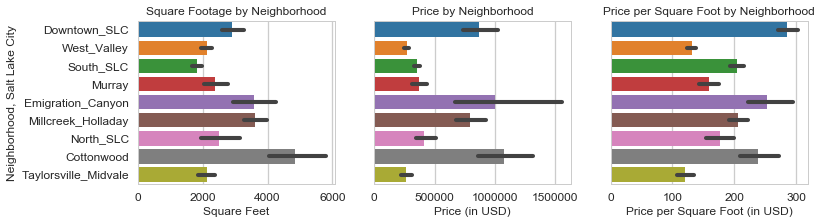

In [446]:
#plotting square footage by neighborhood
fig = plt.figure(figsize=[12,3])
sns.set_style("whitegrid")

fig.add_subplot(131)   #left
ax = sns.barplot(y="neighborhood", x="sqft", data=address_data)
plt.xlabel('Square Feet', fontsize=12)
plt.ylabel('Neighborhood, Salt Lake City', x=2, fontsize=12)
plt.title('Square Footage by Neighborhood', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)

#plotting price by neighborhood
fig.add_subplot(132)   #middle
ax = sns.barplot(y="neighborhood", x="price", data=address_data)
plt.xlabel('Price (in USD)', fontsize=12)
ax.get_yaxis().set_visible(False)
plt.title('Price by Neighborhood', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)

#plotting price per square foot by neighborhood
fig.add_subplot(133)   #right
ax = sns.barplot(y="neighborhood", x="price_per_sqft", data=address_data)
plt.xlabel('Price per Square Foot (in USD)', fontsize=12)
ax.get_yaxis().set_visible(False)
plt.title('Price per Square Foot by Neighborhood', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)

plt.show()

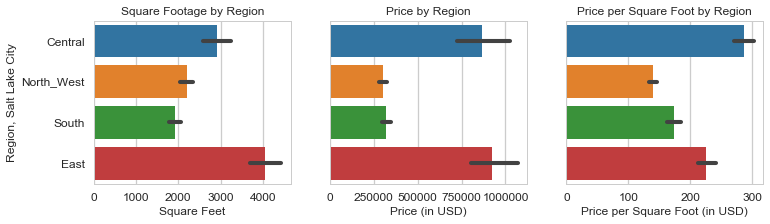

In [447]:
#plotting square footage by region
fig = plt.figure(figsize=[12,3])
sns.set_style("whitegrid")

fig.add_subplot(131)   #left
ax = sns.barplot(y="region", x="sqft", data=address_data)
plt.xlabel('Square Feet', fontsize=12)
plt.ylabel('Region, Salt Lake City', x=2, fontsize=12)
plt.title('Square Footage by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)

#plotting price by region
fig.add_subplot(132)   #middle
ax = sns.barplot(y="region", x="price", data=address_data)
plt.xlabel('Price (in USD)', fontsize=12)
ax.get_yaxis().set_visible(False)
plt.title('Price by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)

#plotting price per square foot by region
fig.add_subplot(133)   #right
ax = sns.barplot(y="region", x="price_per_sqft", data=address_data)
plt.xlabel('Price per Square Foot (in USD)', fontsize=12)
ax.get_yaxis().set_visible(False)
plt.title('Price per Square Foot by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)

plt.show()

# Plotting the Distribution of Size, Price, and Price per SQFT by Region

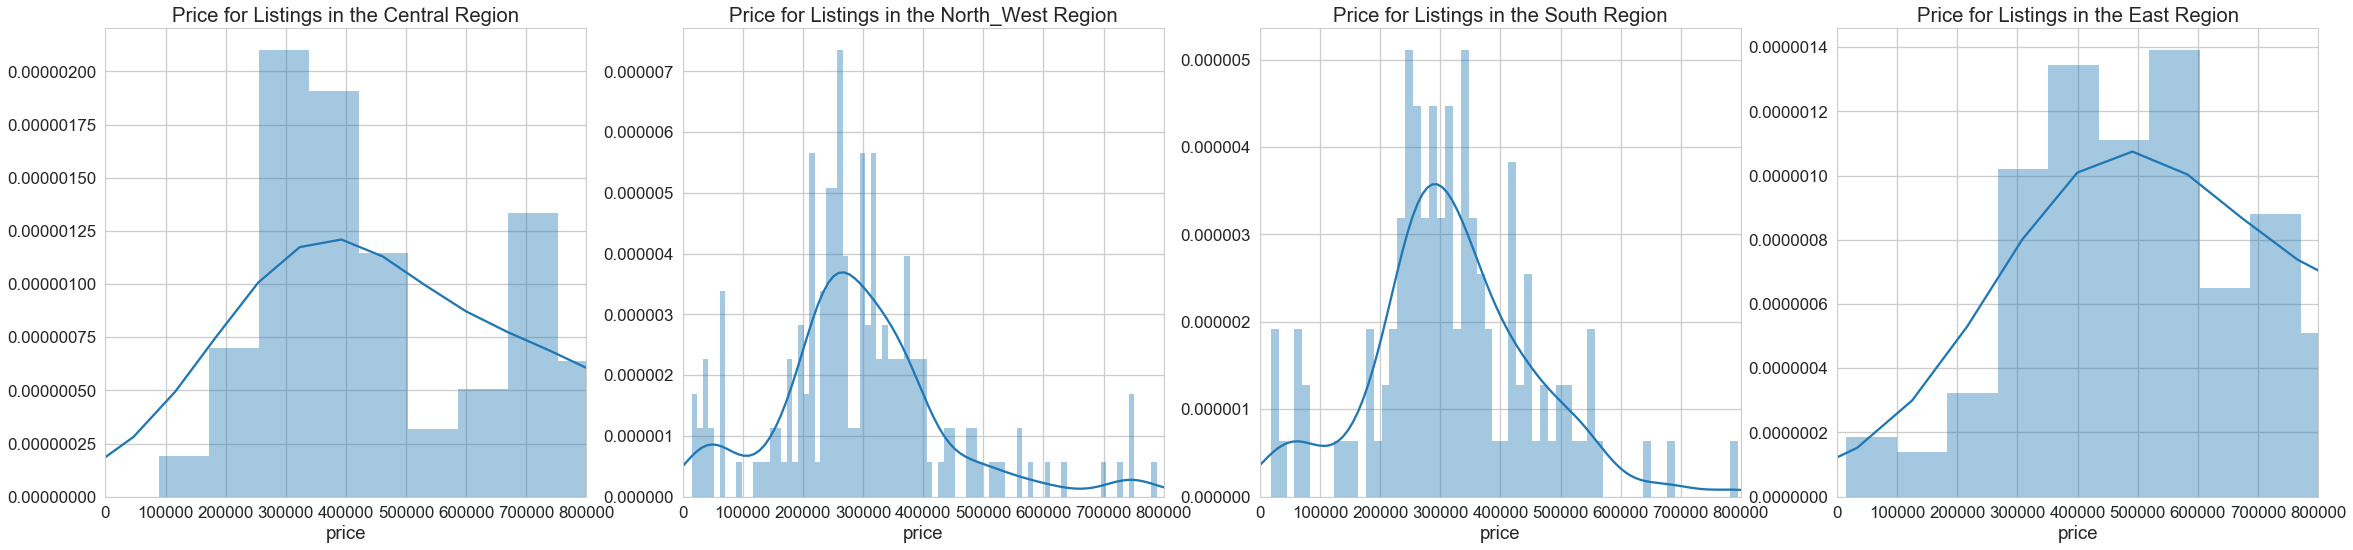

In [476]:
# plotting the price distribution by region

region_list = list(address_data['region'].unique())

#make the axes fonts bigger
sns.set_context("talk", font_scale=1.3)
sns.set_style("whitegrid")
fig = plt.figure(figsize=[50, 50])

sub_plot_num = 1

for region in region_list:
    region_listings = address_data[address_data['region'] == region]
    fig.add_subplot(5,5, sub_plot_num)
    x = .5
    upper = 800000
    bins = int(len(region_listings)*x)
    plot1 = region_listings['price']
    sns.distplot(plot1, bins=bins, kde=True)
    plt.title('Price for Listings in the {} Region'.format(region))
    plt.xlim(100, upper)
    sub_plot_num +=1

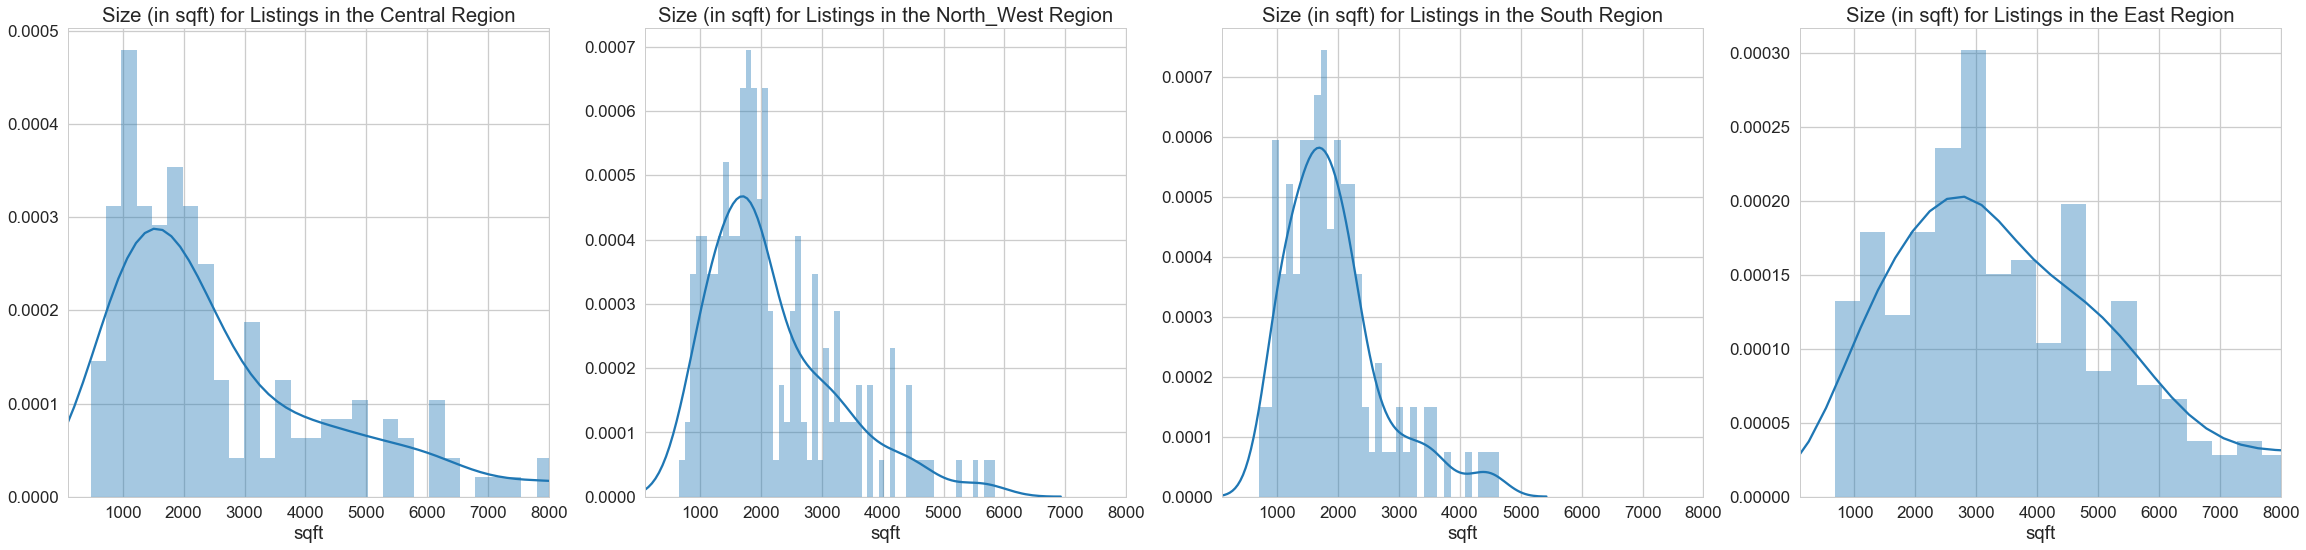

In [516]:
# plotting the price distribution by region

region_list = list(address_data['region'].unique())

#make the axes fonts bigger
sns.set_context("talk", font_scale=1.3)
sns.set_style("whitegrid")
fig = plt.figure(figsize=[50, 50])

sub_plot_num = 1

for region in region_list:
    region_listings = address_data[address_data['region'] == region]
    fig.add_subplot(5,5, sub_plot_num)
    x = .3
    upper = 8000
    bins = int(len(region_listings)*x)
    plot1 = region_listings['sqft']
    sns.distplot(plot1, bins=bins, kde=True)
    plt.title('Size (in sqft) for Listings in the {} Region'.format(region))
    plt.xlim(100, upper)
    sub_plot_num +=1

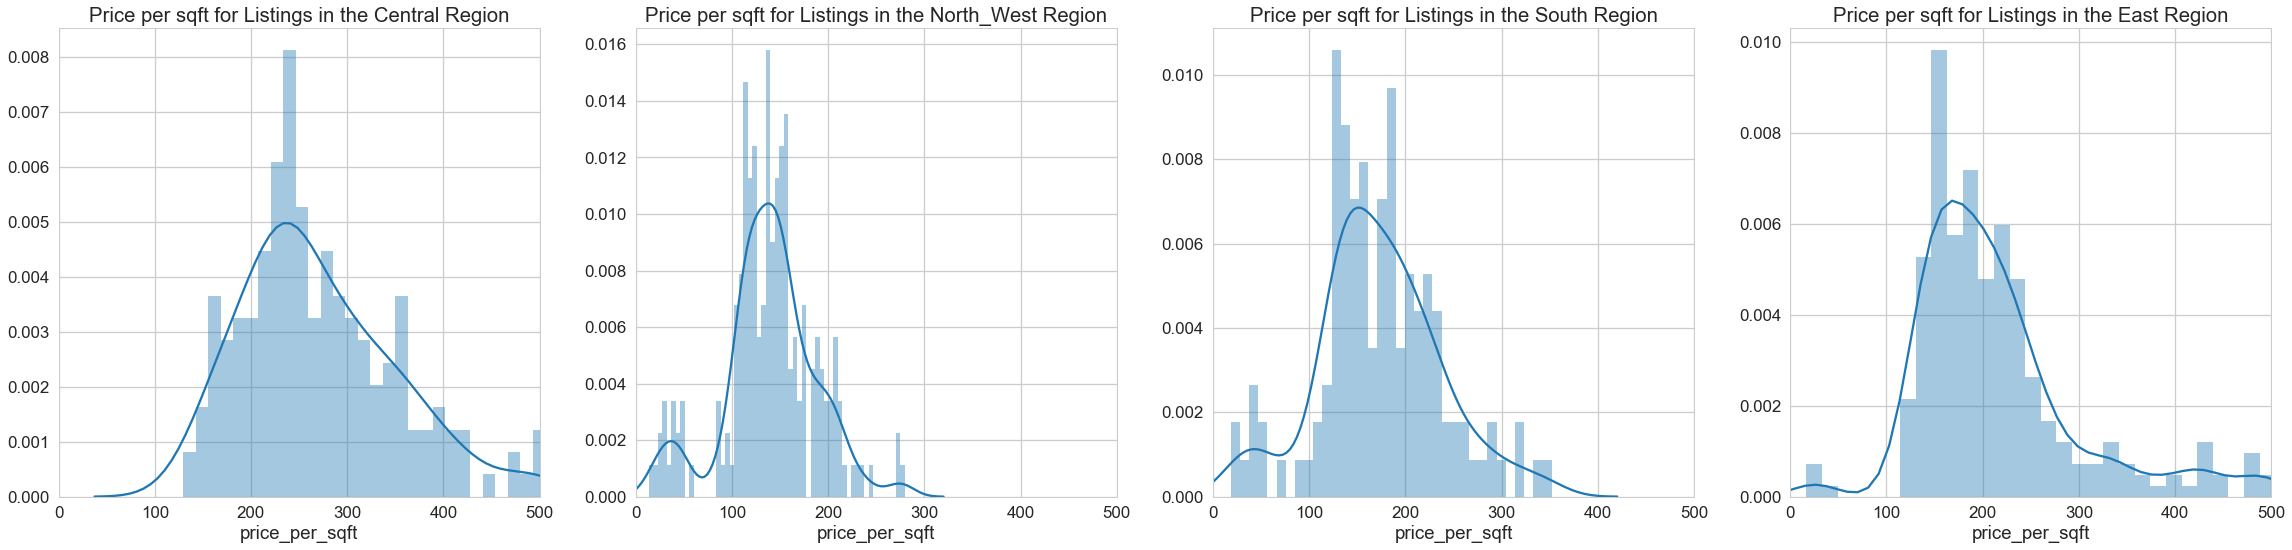

In [479]:
# plotting the size distribution by region

region_list = list(address_data['region'].unique())

#make the axes fonts bigger
sns.set_context("talk", font_scale=1.3)
sns.set_style("whitegrid")
fig = plt.figure(figsize=[50, 50])

sub_plot_num = 1

for region in region_list:
    region_listings = address_data[address_data['region'] == region]
    fig.add_subplot(5, 5, sub_plot_num)
    x = 0.3
    lower = 0
    upper = 500
    bins = int(len(region_listings)*x)
    plot1 = region_listings['price_per_sqft']
    sns.distplot(plot1, bins=bins, kde=True)
    plt.title('Price per sqft for Listings in the {} Region'.format(region))
    plt.xlim(lower, upper)
    sub_plot_num +=1

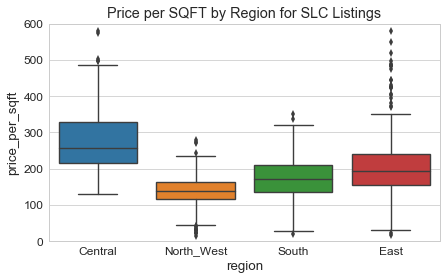

In [490]:
###### plotting the price/median price by neighborhoods

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

fig = plt.figure(figsize=[7, 4])

lower = 0   # set lower x axis limit  
upper = 600  # upper lower x axis limit

fig.add_subplot(111)   #top left
ax = sns.boxplot(x="region", y="price_per_sqft", data=address_data)
ax.set_title('Price per SQFT by Region for SLC Listings')
plt.ylim(lower, upper)

plt.show()

### Create and explore a categorical variable for size type (small, medium, large)

In [499]:
size_type_dict = {}
for column, item in address_data['sqft'].iteritems():
    if item < 1200:
        size_type = 'small'
        size_type_dict[column] = size_type
    elif item > 2400:
        size_type = 'large'
        size_type_dict[column] = size_type
    else:
        size_type = 'medium'
        size_type_dict[column] = size_type
        
size_type_dict_df = pd.DataFrame.from_dict(size_type_dict, orient='index')
size_type_dict_df.columns = ['size_type']

In [ ]:
# join size_type to the existing data frame
address_data = address_data.join(size_type_dict_df, how='left')

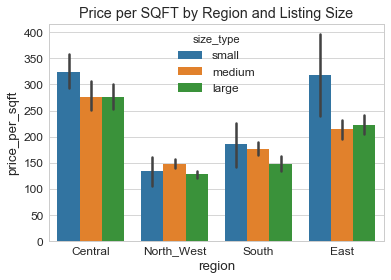

In [501]:
ax = sns.barplot(x="region", y="price_per_sqft", hue = 'size_type', data=address_data)
plt.title('Price per SQFT by Region and Listing Size')
plt.show()

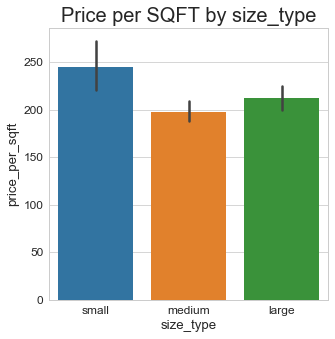

In [502]:
#plotting price per sqft by size_type
fig = plt.figure(figsize=[5,5])
ax = sns.barplot(x="size_type", y="price_per_sqft", data=address_data)
plt.title('Price per SQFT by size_type', y=1, fontsize=20)
plt.show()

## Exporting the Cleaned, Processed Active Listing Data

Here I exported the data frame to a csv so the fully processed data could be imported to the project overview notebook for summary visualizations.

In [503]:
address_data.to_csv('zillow_slc_current_listings_processed.csv')

# Plot size and bedroom count to get a good approximation for my further analysis

In [513]:
# obtain pearson coefficient for parametric parameters
address_data[['sqft', 'beds']].corr(method='pearson')

,sqft,beds
sqft,1.00,0.58
beds,0.58,1.00


In [57]:
sqft_by_beds = (address_data.groupby('beds')['sqft'].describe()).reset_index()

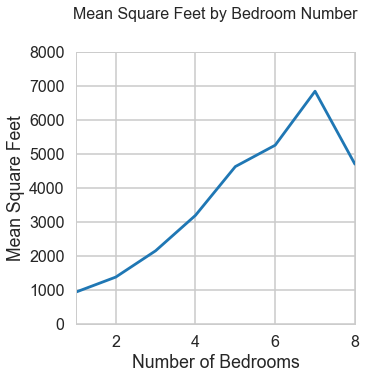

In [515]:
y=(address_data.groupby('beds')['sqft'].describe()).reset_index()['mean']
x=(address_data.groupby('beds')['sqft'].describe()).reset_index()['beds']

#make the axes fonts bigger
sns.set_context("poster")
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)

plt.plot(x,y)
plt.ylabel('Mean Square Feet')
plt.xlabel('Number of Bedrooms')

plt.title('Mean Square Feet by Bedroom Number', y=1.1, fontsize=16)
plt.xlim(1, 8)
plt.ylim(0, 8000)
plt.show()

In [59]:
address_data.groupby(['beds', 'baths'])['sqft'].describe()

count                 mean                  std  \
beds  baths                                                                  
 1.00  1.00                18.00               816.61               252.31   
       2.00                 1.00             1,511.00                  nan   
       3.00                 1.00             2,336.00                  nan   
 2.00  1.00                39.00             1,094.26               342.16   
       2.00                79.00             1,306.56               359.36   
       2.50                 1.00             3,000.00                  nan   
       3.00                11.00             2,174.82               690.87   
       4.00                 1.00             2,491.00                  nan   
 3.00  1.00                31.00             1,522.16               421.96   
       1.50                 1.00             1,976.00                  nan   
       2.00                92.00             1,692.91               506.17   
       2.50                 3.00             1,761.33                57.84   
       3.00                74.00             2,703.49               955.60   
       3.50                 1.00             1,812.00                  nan   
       4.00                 8.00             3,326.25               953.79   
       5.00                 1.00             5,000.00                  nan   
       7.00                 1.00             6,200.00                  nan   
 4.00  1.00                 4.00             1,685.50                77.41   
       2.00                51.00             1,999.47               488.79   
       2.50                 2.00             1,881.00               380.42   
       3.00                55.00             2,826.04               791.68   
       4.00                39.00             3,545.72             1,068.01   
       5.00                12.00             5,672.67             1,129.32   
       6.00                 6.00             7,616.17             2,508.02   
       7.00                 1.00            10,452.00                  nan   
 5.00  1.00                 3.00             2,098.00               582.13   
       2.00                14.00             2,355.86               622.94   
       3.00                35.00             3,197.54               846.63   
       4.00                25.00             3,956.92             1,026.86   
       5.00                 7.00             5,373.29               985.45   
       5.50                 1.00             7,884.00                  nan   
       6.00                 9.00             6,353.22             1,218.55   
       7.00                 5.00             9,314.40             2,327.65   
       9.00                 2.00            12,069.00             3,973.94   
      16.00                 2.00            27,428.00             7,120.57   
 6.00  2.00                 2.00             3,047.00               193.75   
       3.00                14.00             3,483.21             1,040.62   
       4.00                13.00             4,568.62               894.47   
       5.00                15.00             6,110.00               828.86   
       6.00                 5.00             6,140.20             1,339.26   
       7.00                 7.00             8,208.71               996.63   
 7.00  2.75                 1.00             2,530.00                  nan   
       4.00                 6.00             5,256.17             2,597.71   
       5.00                 5.00             5,749.60             1,071.30   
       6.00                 1.00             8,655.00                  nan   
       7.00                 3.00             9,587.33               401.26   
       9.00                 2.00            10,817.50             3,058.24   
 8.00  4.00                 2.00             3,723.00               643.47   
 9.00  5.00                 1.00             7,126.00                  nan   
10.00  5.00                 1.00             4,75